# RHEED Simulation: MgO (001) Surface with <100> Beam

This tutorial demonstrates kinematic RHEED simulation for MgO following the approach in arXiv:2207.06642.

## Experimental Setup:
- **Crystal**: MgO (magnesium oxide, rock salt structure)
- **Surface**: (001) orientation
- **Beam direction**: <100> (along x-axis)
- **Electron energy**: 20 keV
- **Grazing angle**: 2°

## Expected Pattern:
For MgO (001) with <100> beam, we expect:
- Vertical streaks perpendicular to the beam
- Mirror symmetry about the vertical axis
- Streak spacing determined by surface reciprocal lattice

In [19]:
import jax.numpy as jnp
import rheedium as rh

### Use `autoreload` to reload changed modules, you may disable this for normal use.

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
structure_file = rh.inout.parse_cif("../tests/test_data/MgO.cif")

In [22]:
structure_file

CrystalStructure(frac_positions=Array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.20000000e+01],
       [5.00000000e-01, 5.00000000e-01, 0.00000000e+00, 1.20000000e+01],
       [5.00000000e-01, 1.05858729e-33, 5.00000000e-01, 1.20000000e+01],
       [1.05858729e-33, 5.00000000e-01, 5.00000000e-01, 1.20000000e+01],
       [1.05858729e-33, 1.05858729e-33, 5.00000000e-01, 8.00000000e+00],
       [5.00000000e-01, 0.00000000e+00, 0.00000000e+00, 8.00000000e+00],
       [1.05858729e-33, 5.00000000e-01, 0.00000000e+00, 8.00000000e+00],
       [5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 8.00000000e+00]],      dtype=float64), cart_positions=Array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.20000000e+01],
       [2.12824200e+00, 2.12824200e+00, 0.00000000e+00, 1.20000000e+01],
       [2.12824200e+00, 1.30317238e-16, 2.12824200e+00, 1.20000000e+01],
       [2.60634475e-16, 2.12824200e+00, 2.12824200e+00, 1.20000000e+01],
       [1.30317238e-16, 1.30317238e-16, 2.12824200e+00,

In [23]:
# MgO (001) surface with <100> beam direction
# The CIF file already has (001) as the surface (z-direction)
# For RHEED: beam along <100> direction (x-axis) at grazing angle

zone_axis = jnp.array([0, 0, 1])  # (001) surface normal
beam_direction = jnp.array([1, 0, 0])  # <100> beam along x-axis

# Now, load the parameters

In [24]:
# RHEED simulation parameters for MgO (001) surface, <100> beam
voltage_kV = 10.0  # Electron beam voltage in kV (typical for RHEED)
theta_deg = 2.0  # Grazing angle (1-3 degrees typical for RHEED)
phi_deg = 0.0  # Beam along x-axis (<100> direction)
hmax, kmax = 4, 4  # In-plane reciprocal lattice bounds
detector_distance = 80.0  # Detector distance in mm (typical RHEED geometry)
points_per_streak = 100  # Number of points to sample along each CTR streak

# Now, we will process things step by step.

## Electron wavelength (Å)

In [25]:
lam_ang = rh.simul.wavelength_ang(voltage_kV)
lam_ang

Array(0.12200456, dtype=float64, weak_type=True)

## Build real-space lattice vectors

In [26]:
cell_vectors = rh.ucell.build_cell_vectors(
    *structure_file.cell_lengths, *structure_file.cell_angles
)

In [27]:
cell_vectors

Array([[4.25648400e+00, 0.00000000e+00, 0.00000000e+00],
       [2.60634475e-16, 4.25648400e+00, 0.00000000e+00],
       [2.60634475e-16, 2.60634475e-16, 4.25648400e+00]], dtype=float64)

## Generate reciprocal lattice vectors

In [28]:
# For the streak simulator, we don't need to pre-generate reciprocal points
# The simulator handles CTRs internally. But we can still visualize the reciprocal lattice:
lmax = 2  # Just for visualization of bulk reciprocal lattice
Gs = rh.ucell.generate_reciprocal_points(
    crystal=structure_file, hmax=hmax, kmax=kmax, lmax=lmax, in_degrees=True
)
print(f"Reciprocal lattice points (for reference): {Gs.shape[0]}")

Reciprocal lattice points (for reference): 405


## Incident wavevector

In [29]:
k_in = rh.simul.incident_wavevector(lam_ang, theta_deg)
k_in

Array([51.46822109,  0.        , -1.79730988], dtype=float64)

## Build EwaldData for efficient angle scanning

The `build_ewald_data` function pre-computes all angle-independent quantities
(reciprocal lattice, structure factors with Kirkland form factors and Debye-Waller).
This enables efficient reuse when scanning beam angles.

In [30]:
# Build EwaldData - pre-compute structure factors and reciprocal lattice
# This only needs to be done once per crystal/voltage combination
ewald_data = rh.simul.build_ewald_data(
    crystal=structure_file,
    voltage_kv=voltage_kV,
    hmax=hmax,
    kmax=kmax,
    lmax=lmax,
    temperature=300.0,  # Room temperature for Debye-Waller factors
)

print(f"Electron wavelength: {float(ewald_data.wavelength_ang):.4f} Å")
print(f"Wavevector magnitude |k|: {float(ewald_data.k_magnitude):.2f} 1/Å")
print(f"Number of reciprocal lattice points: {ewald_data.g_vectors.shape[0]}")
print(f"HKL grid shape: {ewald_data.hkl_grid.shape}")

Electron wavelength: 0.1220 Å
Wavevector magnitude |k|: 51.50 1/Å
Number of reciprocal lattice points: 405
HKL grid shape: (405, 3)


## Find allowed reflections for specific beam angles

Now use `ewald_allowed_reflections` to find which reflections satisfy the Ewald 
sphere condition for a given beam orientation (theta, phi).

In [31]:
# Find allowed reflections for theta=2°, phi=0° (beam along x-axis)
allowed_idx, k_out_allowed, intensities_allowed = rh.simul.ewald_allowed_reflections(
    ewald=ewald_data,
    theta_deg=theta_deg,
    phi_deg=phi_deg,
    tolerance=0.1,  # 10% tolerance for Ewald sphere intersection
)

# Filter out padding values (-1 indices)
valid_mask = allowed_idx >= 0
n_valid = int(jnp.sum(valid_mask))

print(f"Found {n_valid} allowed reflections at theta={theta_deg}°, phi={phi_deg}°")

# Show the allowed HKL indices
if n_valid > 0:
    valid_idx = allowed_idx[valid_mask]
    valid_hkl = ewald_data.hkl_grid[valid_idx]
    valid_I = intensities_allowed[valid_mask]
    print("\nAllowed reflections (h, k, l) and intensities:")
    for i in range(min(10, n_valid)):  # Show first 10
        h, k, l = valid_hkl[i]
        I = valid_I[i]
        print(f"  ({int(h):2d}, {int(k):2d}, {int(l):2d})  I = {float(I):.4f}")

Found 63 allowed reflections at theta=2.0°, phi=0.0°

Allowed reflections (h, k, l) and intensities:
  (-3, -4,  2)  I = 0.0000
  (-3, -3,  2)  I = 0.0000
  (-3, -2,  2)  I = 0.0000
  (-3, -1,  2)  I = 0.0000
  (-3,  0,  2)  I = 0.0000
  (-3,  1,  2)  I = 0.0000
  (-3,  2,  2)  I = 0.0000
  (-3,  3,  2)  I = 0.0000
  (-3,  4,  2)  I = 0.0000
  (-2, -4,  2)  I = 29.0317


## Azimuthal scan using pre-computed EwaldData

One major advantage of pre-computing EwaldData is efficient azimuthal scans.
The structure factors only need to be computed once!

In [32]:
# Azimuthal scan: find reflections at different phi angles
phi_angles = jnp.linspace(0, 90, 10)  # Scan from 0° to 90°

print("Azimuthal scan results:")
print("-" * 40)
for phi in phi_angles:
    idx, k_out, intensities = rh.simul.ewald_allowed_reflections(
        ewald=ewald_data,
        theta_deg=theta_deg,
        phi_deg=float(phi),
        tolerance=0.1,
    )
    n_refl = int(jnp.sum(idx >= 0))
    total_I = float(jnp.sum(intensities[idx >= 0])) if n_refl > 0 else 0.0
    print(f"  phi = {float(phi):5.1f}°: {n_refl:3d} reflections, total I = {total_I:.2f}")

Azimuthal scan results:
----------------------------------------
  phi =   0.0°:  63 reflections, total I = 765.83
  phi =  10.0°:  63 reflections, total I = 784.32
  phi =  20.0°:  65 reflections, total I = 860.87
  phi =  30.0°:  64 reflections, total I = 837.18
  phi =  40.0°:  65 reflections, total I = 871.54
  phi =  50.0°:  65 reflections, total I = 871.54
  phi =  60.0°:  64 reflections, total I = 837.18
  phi =  70.0°:  65 reflections, total I = 860.87
  phi =  80.0°:  63 reflections, total I = 784.32
  phi =  90.0°:  63 reflections, total I = 765.83


## Simulate RHEED spot pattern using discrete 3D reciprocal lattice

The `kinematic_spot_simulator` treats the reciprocal lattice as discrete 3D points.
This is useful for bulk-like diffraction or when only spot positions matter.
For grazing incidence RHEED, we need a larger `lmax` to capture reflections where
G_z exceeds the incident beam's z-component.

In [33]:
# Generate RHEED spot pattern using discrete 3D reciprocal lattice
# kinematic_spot_simulator finds where discrete G points intersect the Ewald sphere
spot_pattern = rh.simul.kinematic_spot_simulator(
    crystal=structure_file,
    voltage_kv=voltage_kV,
    theta_deg=theta_deg,
    hmax=hmax,
    kmax=kmax,
    lmax=5,  # Need larger lmax for grazing incidence
    detector_distance=detector_distance,
    tolerance=0.05,
)

print(f"Number of spots: {len(spot_pattern.intensities)}")
print(f"X-coordinate range: [{spot_pattern.detector_points[:, 0].min():.2f}, {spot_pattern.detector_points[:, 0].max():.2f}] mm")
print(f"Y-coordinate range: [{spot_pattern.detector_points[:, 1].min():.2f}, {spot_pattern.detector_points[:, 1].max():.2f}] mm")

Number of spots: 891
X-coordinate range: [-10.37, 2.29] mm
Y-coordinate range: [1.59, 40.85] mm


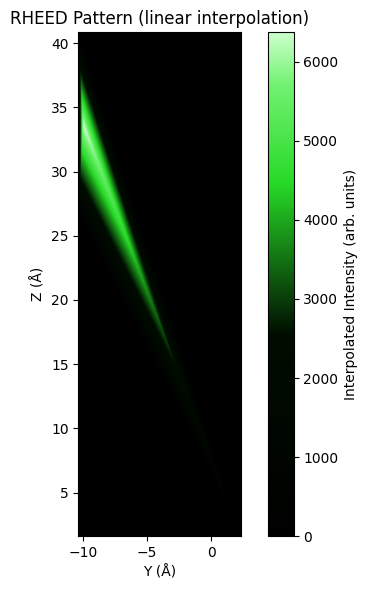

In [34]:
# Plot the spot pattern
rh.plots.plot_rheed(spot_pattern, grid_size=300, interp_type="linear")

## Simulate RHEED streak pattern using Crystal Truncation Rods (CTRs)

The `kinematic_ctr_simulator` properly models RHEED as diffraction from a surface where
the reciprocal lattice consists of continuous rods rather than discrete points.
Each rod intersects the Ewald sphere along an arc, producing vertical streaks.

In [35]:
# Generate RHEED streak pattern for MgO (001) with <100> beam
# kinematic_ctr_simulator models continuous crystal truncation rods (CTRs)
# and returns a RHEEDPattern directly
streak_pattern = rh.simul.kinematic_ctr_simulator(
    crystal=structure_file,
    voltage_kv=voltage_kV,
    theta_deg=theta_deg,
    hmax=hmax,
    kmax=kmax,
    detector_distance=detector_distance,
    points_per_rod=points_per_streak,
)

print(f"Number of streak points: {len(streak_pattern.intensities)}")
print(f"X-coordinate range: [{streak_pattern.detector_points[:, 0].min():.2f}, {streak_pattern.detector_points[:, 0].max():.2f}] mm")
print(f"Y-coordinate range: [{streak_pattern.detector_points[:, 1].min():.2f}, {streak_pattern.detector_points[:, 1].max():.2f}] mm")

Number of streak points: 1950
X-coordinate range: [-10.37, 10.37] mm
Y-coordinate range: [1.59, 42.14] mm


## Check how many reflections were found

In [36]:
# Summary of streak pattern
print(f"Number of streak points: {len(streak_pattern.intensities)}")
print(f"Number of unique rods: {len(jnp.unique(streak_pattern.G_indices))}")
print(f"Intensity range: [{streak_pattern.intensities.min():.3f}, {streak_pattern.intensities.max():.3f}]")
print("\nSample detector coordinates (first 5):")
print(streak_pattern.detector_points[:5])

Number of streak points: 1950
Number of unique rods: 39
Intensity range: [0.010, 1.000]

Sample detector coordinates (first 5):
[[-10.36717427  40.84980135]
 [-10.36717427  40.84980135]
 [-10.36717427  40.84980135]
 [-10.36717427  40.84980135]
 [-10.36717427  40.84980135]]


## Visualize the RHEED pattern

The pattern should show vertical streaks characteristic of RHEED from (001) surface with <100> beam.

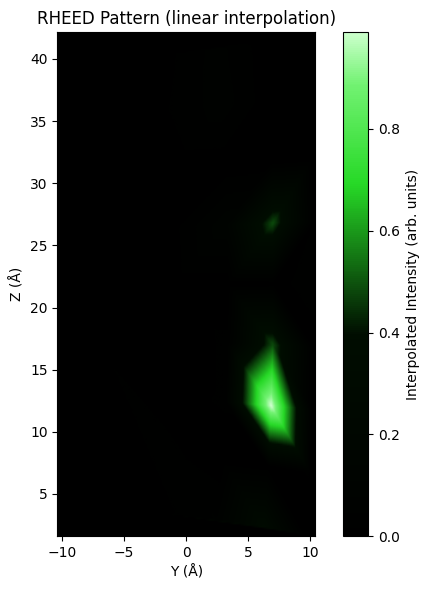

In [37]:
# Plot using the phosphor colormap
# streak_pattern is already a RHEEDPattern from kinematic_ctr_simulator
rh.plots.plot_rheed(streak_pattern, grid_size=300, interp_type="linear")

# Understanding the MgO (001) RHEED Streak Pattern

## Physics of RHEED Streaks

Unlike bulk diffraction (discrete Bragg spots), RHEED from surfaces shows **vertical streaks** because:

1. **Surface breaks z-symmetry**: The reciprocal lattice becomes continuous rods (CTRs) along the surface normal
2. **Rods intersect Ewald sphere**: Each (h,k) rod intersects the large Ewald sphere along an arc
3. **Projection creates streaks**: These arc intersections project onto the detector as vertical lines

## Key Features:
- **Vertical streaks**: Each streak corresponds to an (h,k) CTR
- **Streak spacing**: Determined by in-plane reciprocal lattice (∝ 1/a)
- **Intensity variation**: CTR intensity varies as 1/sin²(πl), brightest at Bragg positions
- **Streak length**: Depends on Ewald sphere curvature and accessible l-range

## MgO Structure:
- Rock salt structure (fcc)
- (001) surface: square lattice with a = 4.26 Å
- For <100> beam: observe (h,0) streaks as the primary vertical features